<a href="https://colab.research.google.com/github/sampritich/samplerepo/blob/master/Copy_of_Transfer_learning_module6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://www.dropbox.com/s/ydxkvvuzf1bcx6n/data.zip

--2019-11-13 07:03:31--  https://www.dropbox.com/s/ydxkvvuzf1bcx6n/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ydxkvvuzf1bcx6n/data.zip [following]
--2019-11-13 07:03:31--  https://www.dropbox.com/s/raw/ydxkvvuzf1bcx6n/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4675dd814770165a82f771959b.dl.dropboxusercontent.com/cd/0/inline/AsQx3gpT8r5ea8iBGj4z2wc572Eecj2XYkw-XTA9kCwZe-JbbkQEA_FJEi8YkQkHdUmGrQwmQB4tAVvsXdhqM0yicWxm9X1adzV929FdRyD_EmDqVffgiQnnKLpvEkoznPU/file# [following]
--2019-11-13 07:03:31--  https://uc4675dd814770165a82f771959b.dl.dropboxusercontent.com/cd/0/inline/AsQx3gpT8r5ea8iBGj4z2wc572Eecj2XYkw-XTA9kCwZe-JbbkQEA_FJEi8YkQkHdUmGrQwmQB4tAVvsXdhqM0yicWxm9X1adzV929FdRyD_EmDqVffgiQnnKLp

In [0]:
!unzip /content/data.zip


Archive:  /content/data.zip
replace data/test/cats/cat.250.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: cat
error:  invalid response [cat]
replace data/test/cats/cat.250.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# Base variables
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

train_size, validation_size, test_size = 200, 100, 100

img_width, img_height = 224, 224  # Default input size for VGG16

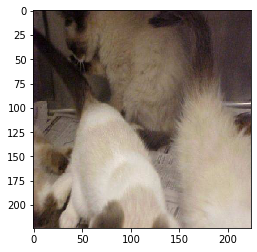

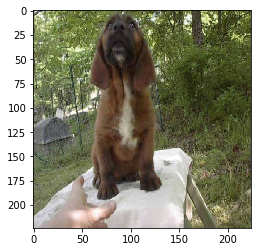

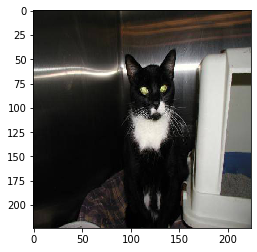

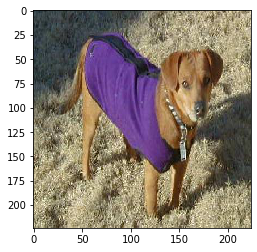

In [0]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

In [0]:
# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [0]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [0]:
# Debug
print(train_features)
print(train_labels)

[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.26106572e+00 0.00000000e+00]
   [4.52078491e-01 0.00000000e+00 7.20084071e-01 ... 0.00000000e+00
    2.87916124e-01 0.00000000e+00]
   [5.98762333e-01 0.00000000e+00 1.20725882e+00 ... 0.00000000e+00
    2.75499165e-01 0.00000000e+00]
   ...
   [5.19201279e-01 0.00000000e+00 6.65525675e-01 ... 0.00000000e+00
    4.69232798e-01 0.00000000e+00]
   [3.96257848e-01 0.00000000e+00 5.13037205e-01 ... 0.00000000e+00
    7.76575923e-01 0.00000000e+00]
   [3.29292148e-01 0.00000000e+00 3.40995222e-01 ... 0.00000000e+00
    6.69948339e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.37238407e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.09806633e+00 ... 4.12275225e-01
    7.87850380e-01 0.00000000e+00]
   [8.20522130e-01 0.00000000e+00 1.07322979e+00 ... 0.00000000e+00
    2.97195971e-01 0.00000000e+00]
   ...
   [4.12006974e-01 0.00000000e+00 3.22047412e-01 ... 0.00

In [0]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 3.2915 - acc: 0.4900 - val_loss: 1.3859 - val_acc: 0.5200
Epoch 2/100
200/200 [==============================] - 0s 743us/step - loss: 1.1542 - acc: 0.6850 - val_loss: 0.8350 - val_acc: 0.6500
Epoch 3/100
200/200 [==============================] - 0s 666us/step - loss: 0.7035 - acc: 0.7650 - val_loss: 0.9322 - val_acc: 0.7000
Epoch 4/100
200/200 [==============================] - 0s 655us/step - loss: 0.2193 - acc: 0.9100 - val_loss: 0.4111 - val_acc: 0.8000
Epoch 5/100
200/200 [==============================] - 0s 675us/step - loss: 0.1492 - acc: 0.9350 - val_loss: 0.4310 - val_acc: 0.8000
Epoch 6/100
200/200 [==============================] - 0s 694us/step - loss: 0.1190 - acc: 0.9600 - val_loss: 0.3968 - val_acc: 0.8100
Epoch 7/100
200/200 [==============================] - 0s 691us/step - loss: 0.0625 - acc: 0.9950 - val_loss: 0.4147 - val_acc: 0.8300
Epoch 8/100

In [0]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_cats_dir, test_dogs_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

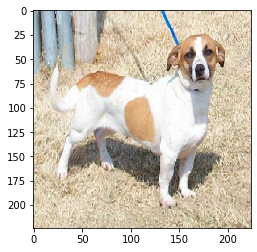

Dog


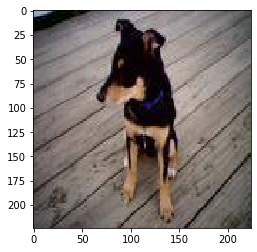

Dog


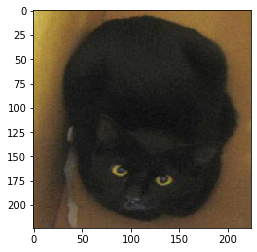

Cat


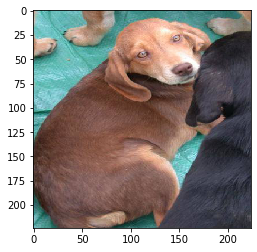

Dog


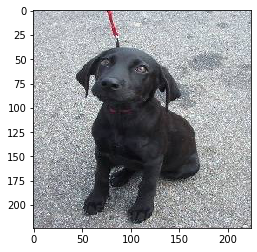

Dog


In [0]:
# Visualize predictions
visualize_predictions(model, 5)

In [0]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [0]:
!pip install scikit-learn

In [0]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# Save model
model.save('dogs_cat_svm.h5')

In [0]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

0.8733333333333334

Accuracy score (standard deviation):


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

0.06289320754704404


In [0]:
# Plot learning curves
from sklearn.model_selection import learning_curve
'''
train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10)
'''
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

In [0]:
# Visualize predictions
visualize_predictions(clf, 5)